## Imports

In [1]:
%matplotlib inline

import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize
from sklearn import cross_validation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
plt.style.use('ggplot')

## Functions

In [3]:
def jitter(values, sd=0.25):
    return [np.random.normal(v, sd) for v in values]

In [4]:
def clean_text(df, col):
    """A function for keeping only alpha-numeric
    characters and replacing all white space with
    a single space.
    """
    return df[col].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x.lower()))\
                  .apply(lambda x: re.sub('\s+', ' ', x).strip())

In [5]:
def count_pattern(df, col, pattern):
    """Count the occurrences of `pattern`
    in df[col].
    """
    df = df.copy()
    return df[col].str.count(pattern)

In [6]:
def split_on_word(text):
    """Use regular expression tokenizer.
    Keep apostrophes.
    Returns a list of lists, one list for each sentence:
        [[word, word], [word, word, ..., word], ...].
    """
    if type(text) is list:
        return [regexp_tokenize(sentence, pattern="\w+(?:[-']\w+)*") for sentence in text]
    else:
        return regexp_tokenize(text, pattern="\w+(?:[-']\w+)*")

In [7]:
def normalize(tokenized_words):
    """Removes stop words, numbers, short words, and lowercases text.
    Returns a list of lists, one list for each sentence:
        [[word, word], [word, word, ..., word], ...].
    """
    stop_words = stopwords.words('english')
    return [[w.lower() for w in sent
             if (w.lower() not in stop_words)]
            for sent in tokenized_words]

In [8]:
def features(df):
    df = df.copy()
    df['n_questionmarks'] = count_pattern(df, 'Text', '\?')
    df['n_periods'] = count_pattern(df, 'Text', '\.')
    df['n_apostrophes'] = count_pattern(df, 'Text', '\'')
    df['first_word'] = df.text_clean.apply(lambda x: split_on_word(x)[0])
    question_words = ['what', 'how', 'why', 'is']
    for w in question_words:
        col_wc = 'n_' + w
        col_fw = 'fw_' + w
        df[col_wc] = count_pattern(df, 'text_clean', w)
        df[col_fw] = (df.first_word == w) * 1
        
    del df['first_word']
    
    df['n_words'] = df.Text.apply(lambda x: len(split_on_word(x)))
    return df

In [9]:
def flatten_words(list1d, get_unique=False):
    qa = [s.split() for s in list1d]
    if get_unique:
        return sorted(list(set([w for sent in qa for w in sent])))
    else:
        return [w for sent in qa for w in sent]

## Data

### Load

In [10]:
training = pd.read_csv('../data/newtrain.csv')

In [11]:
tr_non1 = training[training['Category'] != 1]

In [12]:
tr_non1.shape

(1929, 2)

In [13]:
sample = tr_non1.sample(1000, random_state=1868)

In [14]:
training = training.append(sample)

In [15]:
training.reset_index(drop=True, inplace=True)

In [16]:
training.head()

,Category,Text
0,5,why are yawns contagious? when people yawn
1,6,what is trans fat? how to reduce that? i heard...
2,1,roth ira vs 401k? what is the difference betwe...
3,1,how many planes fedex has? i heard that it is ...
4,2,what is the best photo slideshow creation appl...


In [17]:
training.Category.value_counts()

1    769
2    681
3    611
4    538
5    374
7    372
6    353
dtype: int64

In [18]:
test = pd.read_csv('../data/newtest.csv')

### Clean

Remove non-alpha numeric characters and extra whitespace.

In [19]:
training['text_clean'] = clean_text(training, 'Text')

In [20]:
test['text_clean'] = clean_text(test, 'Text')

### Feature Engineering

#### tfidf

In [21]:
all_text = training['text_clean'].values.tolist() + test['text_clean'].values.tolist()

In [22]:
vocab = flatten_words(all_text, get_unique=True)

In [23]:
tfidf = TfidfVectorizer(stop_words='english', vocabulary=vocab)

In [24]:
training_matrix = tfidf.fit_transform(training.text_clean)

In [25]:
test_matrix = tfidf.fit_transform(test.text_clean)

#### Other Features

In [26]:
training = features(training)

In [27]:
training = pd.concat([training, pd.DataFrame(training_matrix.todense())], axis=1)

In [28]:
test = features(test)

In [29]:
test = pd.concat([test, pd.DataFrame(test_matrix.todense())], axis=1)

### Split the Training Data

In [30]:
train, dev = cross_validation.train_test_split(training, test_size=0.2, random_state=1868)

## Training

In [31]:
svm = LinearSVC(dual=False, max_iter=5000)
logistic = LogisticRegression()
naivebayes = MultinomialNB()
bernoulli = BernoulliNB()

In [32]:
features = train.columns[3:]

In [33]:
X = train[features].values
y = train['Category'].values

In [34]:
features_dev = dev[features].values

### Cross Validation

In [35]:
kf = cross_validation.KFold(n=len(train), n_folds=5)

In [36]:
for clf, label in zip([svm, logistic, naivebayes, bernoulli],
                      ['SVC', 'Logistic Regression', 'multinomial NB', 'Bernoulli NB']):
    print(np.array([clf.fit(X[tr], y[tr]).score(X[te], y[te]) for tr, te in kf]).mean(), label)

0.705532308959 SVC
0.610205446563 Logistic Regression
0.324894247039 multinomial NB
0.359380001829 Bernoulli NB


## Testing on `dev`

### SVM

In [37]:
svm.fit(X, y)
dev_predicted = svm.predict(features_dev)

In [38]:
accuracy_score(dev.Category, dev_predicted)

0.74189189189189186

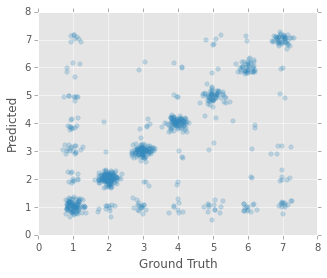

In [39]:
plt.figure(figsize=(5, 4))

plt.scatter(jitter(dev.Category, 0.15),
            jitter(dev_predicted, 0.15),
            color='#348ABD', alpha=0.25)

plt.xlabel('Ground Truth')
plt.ylabel('Predicted')

### Logistic Regression

In [40]:
logistic.fit(X, y)
dev_predicted = logistic.predict(features_dev)

In [41]:
accuracy_score(dev.Category, dev_predicted)

0.65135135135135136

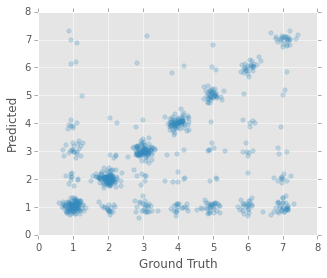

In [42]:
plt.figure(figsize=(5, 4))

plt.scatter(jitter(dev.Category, 0.15),
            jitter(dev_predicted, 0.15),
            color='#348ABD', alpha=0.25)

plt.xlabel('Ground Truth')
plt.ylabel('Predicted')

### Multinomial Naive Bayes

In [43]:
naivebayes.fit(X, y)
dev_predicted = naivebayes.predict(features_dev)

In [44]:
accuracy_score(dev.Category, dev_predicted)

0.38108108108108107

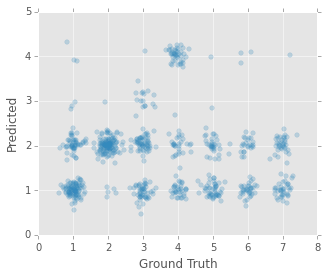

In [45]:
plt.figure(figsize=(5, 4))

plt.scatter(jitter(dev.Category, 0.15),
            jitter(dev_predicted, 0.15),
            color='#348ABD', alpha=0.25)

plt.xlabel('Ground Truth')
plt.ylabel('Predicted')

### Bernoulli Naive Bayes

In [46]:
bernoulli.fit(X, y)
dev_predicted = bernoulli.predict(features_dev)

In [47]:
accuracy_score(dev.Category, dev_predicted)

0.4081081081081081

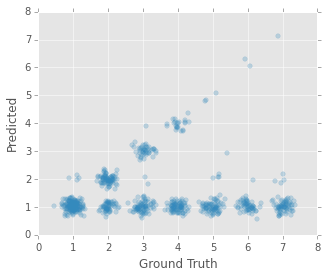

In [48]:
plt.figure(figsize=(5, 4))

plt.scatter(jitter(dev.Category, 0.15),
            jitter(dev_predicted, 0.15),
            color='#348ABD', alpha=0.25)

plt.xlabel('Ground Truth')
plt.ylabel('Predicted')

## Testing

In [49]:
X = training[features].values
y = training['Category'].values

In [50]:
features_test = test[features].values

In [51]:
svm.fit(X, y)
test_predicted = svm.predict(features_test)

In [52]:
test['Category'] = test_predicted

In [53]:
output = test[['Id', 'Category']]

In [54]:
output.to_csv('../data/solution03.csv', index=False)